# Spatio-Temporal Accessibility of Pharmacy Care in Vermont, USA

## Comparing Results of Alternative Study Versions

### Authors

- Sam Roubin, sroubin@middlebury.edu, https://orcid.org/0009-0005-5490-3744, Middlebury College
- Joseph Holler\*, josephh@middlebury.edu, https://orcid.org/0000-0002-2381-2699, Middlebury College
- Peter Kedron, peterkedron@ucsb.edu, https://orcid.org/0000-0002-1093-3416, University of California, Santa Barbara

\* Corresponding author

## **Materials and procedure**

### Computational environment

Similar to Kang et al. (2020), this study was run using CyberGIS-Jupyter. This study uses an updated software environment from the reproduction study, using Python Jupyter Notebooks in the CyberGISX environment available at https://cybergisxhub.cigi.illinois.edu/. In particular, we use the Python 3-0.9.0 Kernel running Python 3.8.12, pandas 1.3.5, geopandas 0.10.2, networkx 2.6.3 and osmnx 1.1.2. 


In [4]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output
from shapely.ops import nearest_points   #for pharmacy_setting function
from scipy.stats import kruskal
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patheffects as path_effects
from tabulate import tabulate
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Patch
import imageio
import math

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
seaborn==0.11.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
IPython==8.3.0
requests==2.27.1
imageio==2.13.5


### Check Directories

In [6]:
# Check working directory
os.getcwd()

'/home/jovyan/work/OR-VT-Pharmacy/procedure/code'

In [7]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'/home/jovyan/work/OR-VT-Pharmacy'

In [368]:
# define the desired result sets to compare
set1 = "012"
set2 = "011"

# save figures? Switch to True to save figures
figsave = True

def make_fig_file(fignum):
    fig_folder = "./results/figures/sets_" + set1 + "_" + set2
    os.makedirs(fig_folder, exist_ok=True)
    return fig_folder + "/figure" + str(fignum) + ".jpg"

In [369]:
# load results
coi = ["access_w", "access_s", "access_su"]
colnames1 = {item: item + set1 for item in coi}
colnames2 = {item: item + set2 for item in coi}

def loadResults(setNum):
    setDesc_file = "./data/derived/public/result_sets/results_" + setNum + ".txt"
    setResult_file = "./data/derived/public/result_sets/results_" + setNum + ".gpkg"
    with open(setDesc_file, 'r') as f:
        setDesc = f.read()
    print(setDesc)
    results = gpd.read_file(setResult_file)
    results = results.loc[:, :'minority_pop'].join(results[coi + ['geometry']])
    return results

print("First Result Set:\n")
results1 = loadResults(set1).rename(columns = colnames1)

print("\nsubtracting Second Result Set:\n")
results2 = loadResults(set2).rename(columns = colnames2)[['GEOID'] + list(colnames2.values())]

results_comb = results1.merge(results2, on="GEOID")

First Result Set:

Result Set ID: 012
Beta: 262
Discretization: min travel time
Distances: [600, 1200, 1800] (seconds) [10, 20, 30] (minutes)
Weights: [1, 0.68, 0.22]
Time series: 2025
Pharmacy technician value: pt5 (0.5)
Demand population: total_pop
Geographic level of aggregation: county_subdivision

subtracting Second Result Set:

Result Set ID: 011
Beta: 262
Discretization: min travel time
Distances: [600, 1200, 1800] (seconds) [10, 20, 30] (minutes)
Weights: [1, 0.68, 0.22]
Time series: 2023
Pharmacy technician value: pt5 (0.5)
Demand population: total_pop
Geographic level of aggregation: county_subdivision


In [370]:
results_comb

,GEOID,NAME,necta,total_pop,elderly_pop,minority_pop,access_w012,access_s012,access_su012,geometry,access_w011,access_s011,access_su011
0,5001773675,"Tunbridge town, Orange County, Vermont",None,1337.0,274.0,55.0,1.111834,0.747232,0.443960,"MULTIPOLYGON (((494016.737 152571.233, 494092....",1.815529,1.019366,0.716094
1,5000975175,"Victory town, Essex County, Vermont",None,70.0,23.0,4.0,1.508539,0.827602,0.669212,"MULTIPOLYGON (((546966.722 227691.457, 547619....",1.508539,0.827602,0.669212
2,5000902162,"Avery's gore, Essex County, Vermont",None,0.0,0.0,0.0,0.005312,0.003187,0.002656,"MULTIPOLYGON (((551630.172 271974.320, 556994....",0.005312,0.003187,0.002656
3,5000159650,"Ripton town, Addison County, Vermont",None,739.0,128.0,86.0,2.000679,1.318757,0.879293,"MULTIPOLYGON (((454852.030 171483.437, 457345....",2.000679,1.318757,0.879293
4,5000108575,"Bridport town, Addison County, Vermont",None,1225.0,282.0,82.0,4.389905,2.686803,1.258349,"MULTIPOLYGON (((426786.611 165125.435, 426899....",4.389905,2.686803,1.258349
...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,5001903550,"Barton town, Orleans County, Vermont",None,2872.0,736.0,168.0,4.423274,2.612045,1.957477,"MULTIPOLYGON (((519223.514 249590.456, 519586....",5.088039,3.110618,2.456050
251,5000126300,"Ferrisburgh town, Addison County, Vermont",Metropolitan NECTA,2646.0,581.0,159.0,2.419016,1.500809,1.162266,"MULTIPOLYGON (((428034.770 184292.295, 428115....",2.439431,1.500809,1.162266
252,5000785150,"Winooski city, Chittenden County, Vermont",Metropolitan NECTA,7997.0,947.0,1674.0,8.981344,5.087106,3.897623,"MULTIPOLYGON (((444153.318 221625.708, 444517....",9.143431,5.087106,3.897623
253,5002756350,"Pomfret town, Windsor County, Vermont",Micropolitan NECTA,916.0,265.0,53.0,2.193776,1.001098,0.789641,"MULTIPOLYGON (((492994.175 129381.628, 494043....",2.571441,1.096089,0.884632


In [371]:
# Calculate Difference and Pct Difference
for i in coi:
    results_comb[i] = results_comb[i + set1] - results_comb[i + set2]
    results_comb[i + "pctdif"] = results_comb[i] / (results_comb[i + set1] + results_comb[i + set2]) * 100
    
results_comb
mapping_df = results_comb
mapping_df

,GEOID,NAME,necta,total_pop,elderly_pop,minority_pop,access_w012,access_s012,access_su012,geometry,access_w011,access_s011,access_su011,access_w,access_wpctdif,access_s,access_spctdif,access_su,access_supctdif
0,5001773675,"Tunbridge town, Orange County, Vermont",None,1337.0,274.0,55.0,1.111834,0.747232,0.443960,"MULTIPOLYGON (((494016.737 152571.233, 494092....",1.815529,1.019366,0.716094,-0.703695,-24.038519,-0.272134,-15.404432,-0.272134,-23.458774
1,5000975175,"Victory town, Essex County, Vermont",None,70.0,23.0,4.0,1.508539,0.827602,0.669212,"MULTIPOLYGON (((546966.722 227691.457, 547619....",1.508539,0.827602,0.669212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5000902162,"Avery's gore, Essex County, Vermont",None,0.0,0.0,0.0,0.005312,0.003187,0.002656,"MULTIPOLYGON (((551630.172 271974.320, 556994....",0.005312,0.003187,0.002656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5000159650,"Ripton town, Addison County, Vermont",None,739.0,128.0,86.0,2.000679,1.318757,0.879293,"MULTIPOLYGON (((454852.030 171483.437, 457345....",2.000679,1.318757,0.879293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5000108575,"Bridport town, Addison County, Vermont",None,1225.0,282.0,82.0,4.389905,2.686803,1.258349,"MULTIPOLYGON (((426786.611 165125.435, 426899....",4.389905,2.686803,1.258349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,5001903550,"Barton town, Orleans County, Vermont",None,2872.0,736.0,168.0,4.423274,2.612045,1.957477,"MULTIPOLYGON (((519223.514 249590.456, 519586....",5.088039,3.110618,2.456050,-0.664765,-6.989201,-0.498574,-8.712266,-0.498574,-11.296489
251,5000126300,"Ferrisburgh town, Addison County, Vermont",Metropolitan NECTA,2646.0,581.0,159.0,2.419016,1.500809,1.162266,"MULTIPOLYGON (((428034.770 184292.295, 428115....",2.439431,1.500809,1.162266,-0.020416,-0.420207,0.000000,0.000000,0.000000,0.000000
252,5000785150,"Winooski city, Chittenden County, Vermont",Metropolitan NECTA,7997.0,947.0,1674.0,8.981344,5.087106,3.897623,"MULTIPOLYGON (((444153.318 221625.708, 444517....",9.143431,5.087106,3.897623,-0.162087,-0.894284,0.000000,0.000000,0.000000,0.000000
253,5002756350,"Pomfret town, Windsor County, Vermont",Micropolitan NECTA,916.0,265.0,53.0,2.193776,1.001098,0.789641,"MULTIPOLYGON (((492994.175 129381.628, 494043....",2.571441,1.096089,0.884632,-0.377665,-7.925450,-0.094992,-4.529473,-0.094992,-5.673595


## **Results**



### Hypothesis 1 - Spatial Dimension

Calculate mean access by NECTA type.

In [372]:
# Weekday accessibility by classification table
mapping_df['necta'].fillna('Rural', inplace=True)
# Replace 'Metropolitan NECTA' and 'Micropolitan NECTA' with 'Metropolitan' and 'Micropolitan', respectively
mapping_df['necta'] = mapping_df['necta'].replace({'Metropolitan NECTA': 'Metropolitan', 'Micropolitan NECTA': 'Micropolitan'})

# Group by NECTA and calculate means
means_by_metro = mapping_df.groupby('necta').mean()
weekdaymean_by_metro = means_by_metro[['access_w']]

weekdaymean_by_metro.columns = ['Mean Access']
table_1 = tabulate(weekdaymean_by_metro, headers='keys', tablefmt='simple_grid')
print(table_1)

necta           Mean Access
------------  -------------
Metropolitan     0.00293967
Micropolitan    -0.312158
Rural           -0.260217


#### Figure 2: Weekday accessibility

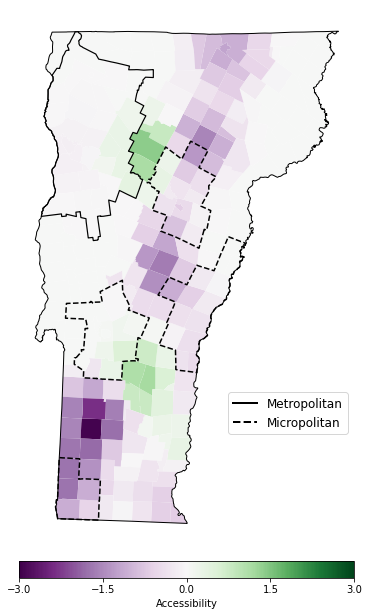

In [373]:
# Map of weekday pharmacy accessibility
fig2, ax = plt.subplots(figsize=(12, 12), facecolor = 'white')

extreme = math.ceil(max([abs(min(mapping_df['access_w'])) , max(mapping_df['access_w']) ]))

mapping_df.plot(column='access_w', cmap='PRGn', legend = False, ax=ax, vmax=extreme, vmin=-extreme)
mapping_df.dissolve().boundary.plot(ax=ax, color='black', linewidth=1)

# Dissolve the geometries for each group to merge adjacent polygons 
metropolitan_df = mapping_df[mapping_df['necta'] == 'Metropolitan']
micropolitan_df = mapping_df[mapping_df['necta'] == 'Micropolitan']

metropolitan_boundary = metropolitan_df.dissolve(by='necta')['geometry'].boundary
micropolitan_boundary = micropolitan_df.dissolve(by='necta')['geometry'].boundary

# Plot exterior boundaries of the 'Metropolitan NECTA' group
metropolitan_boundary.plot(ax=ax, color='black', linewidth=1.2)

# Plot exterior boundaries of the 'Micropolitan NECTA' group
micropolitan_boundary.plot(ax=ax, color='black',linestyle = "dashed", linewidth=1.5)

legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Metropolitan'),
    Line2D([0], [0], color='black', linestyle = 'dashed',lw=2, label='Micropolitan')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=12, bbox_to_anchor=(1,.2))
colorbar = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(vmin=-extreme, vmax=extreme))

# Colorbar settings
cbar = plt.colorbar(colorbar, shrink = .5, pad=.02, label = 'Difference in Accessibility', location="bottom")
cbar.set_ticks([-extreme, -(extreme/2), 0, extreme/2, extreme])

    
plt.axis('off')
plt.show()

# Save figure
if figsave:
    fig2.savefig(make_fig_file(2), dpi=300)

**Figure 2.** Spatial accessibility during conventional weekday business hours, representing a time period when all pharmacies are operational (maximum accessibility). 

#### Statistical Significance

Not normal distribution. Cannot use ANOVA test. Use Kruskal-Wallis instead.


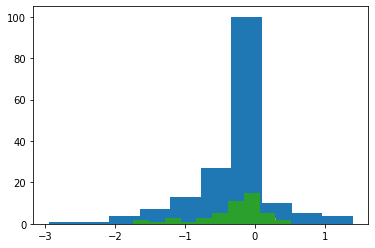

In [374]:
# Check for normal distribution in weekday metro, micro, rural
access_w_metro = mapping_df[mapping_df['necta'] == 'Metropolitan']['access_w']
access_w_micro = mapping_df[mapping_df['necta'] == 'Micropolitan']['access_w']
access_w_rural = mapping_df[mapping_df['necta'] == 'Rural']['access_w']

plt.hist(access_w_rural, bins=10)
plt.hist(access_w_metro, bins=10)
plt.hist(access_w_micro, bins=10)
print("Not normal distribution. Cannot use ANOVA test. Use Kruskal-Wallis instead.")

In [375]:
# Kruskal Wallis Test for significant difference of means between necta classification during conventional business hours
h_statistic_1, p_value_1 = kruskal(access_w_metro, access_w_micro, access_w_rural)
                 
print("Kruskal-Wallis H Statistic:", h_statistic_1)
print("P-value:", p_value_1)

alpha = 0.05
if p_value_1 < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean access during conventional weekday \nbusiness hours between metropolitan, micropolitan, and rural towns.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean access between groups.")

Kruskal-Wallis H Statistic: 3.851823055737779
P-value: 0.14574284762289536
Fail to reject the null hypothesis. There is no significant difference in mean access between groups.


In [376]:
dunn_data = np.concatenate([access_w_metro, access_w_micro, access_w_rural])
dunn_groups = ['access_w_metro']*len(access_w_metro) + ['access_w_micro']*len(access_w_micro) + ['access_w_rural']*len(access_w_rural)
dunn_df = pd.DataFrame({'value': dunn_data, 'group': dunn_groups})

# Perform Dunn's test with p-value adjustment (e.g., 'holm')
dunn_results = sp.posthoc_dunn(dunn_df, val_col='value', group_col='group', p_adjust='holm')
print("\nDunn's Post Hoc Test Results (p-values):\n", dunn_results)


Dunn's Post Hoc Test Results (p-values):
                 access_w_metro  access_w_micro  access_w_rural
access_w_metro        1.000000        0.160367        0.223361
access_w_micro        0.160367        1.000000        0.410703
access_w_rural        0.223361        0.410703        1.000000


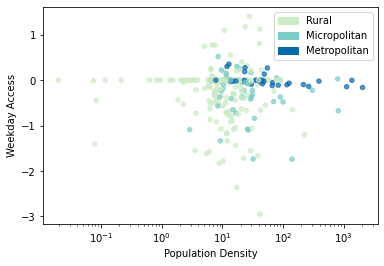

In [377]:
# Create the scatter plot
import matplotlib.patches as mpatches

nectas = {'Rural': '#ccebc5',
          'Micropolitan': '#7bccc4', 
          'Metropolitan': '#0868ac'
          }

color_list = [nectas[group] for group in mapping_df['necta']]

legend_handles = []
for key, value in nectas.items():
    patch = mpatches.Patch(color=value, label=key)
    legend_handles.append(patch)

mapping_df['pop_density'] = mapping_df['total_pop'] / (mapping_df.geometry.area / 10**6)
mapping_df.plot.scatter('pop_density', 'access_w', c=color_list, alpha=0.7)

# Add labels and title
plt.xlabel("Population Density")
plt.xscale('log')
plt.ylabel("Weekday Access")
plt.legend(handles=legend_handles)

Scatterplot of Population and Weekday Access to illustrate relationship between NECTA classification, population density of county subdivisions, and spatial accessibility.

### Hypothesis 2 - Temporal Dimension

Calculate mean access by type of day, and then map accessibility by county subdivision for each type of day.

In [378]:
# Mean accessibility by day table
mean_access_day = mapping_df[['access_w', 'access_s', 'access_su']].mean()
mean_access_day_df = mean_access_day.to_frame().rename(columns={0: 'Mean Access'})
mean_access_day_df.index = ['Weekday', 'Saturday', 'Sunday']
table_2 = tabulate(mean_access_day_df, headers='keys', tablefmt='simple_grid')
print(table_2)

            Mean Access
--------  -------------
Weekday      -0.233874
Saturday     -0.136123
Sunday       -0.0651733


#### Figure 3: Accessibility variation by day of the week

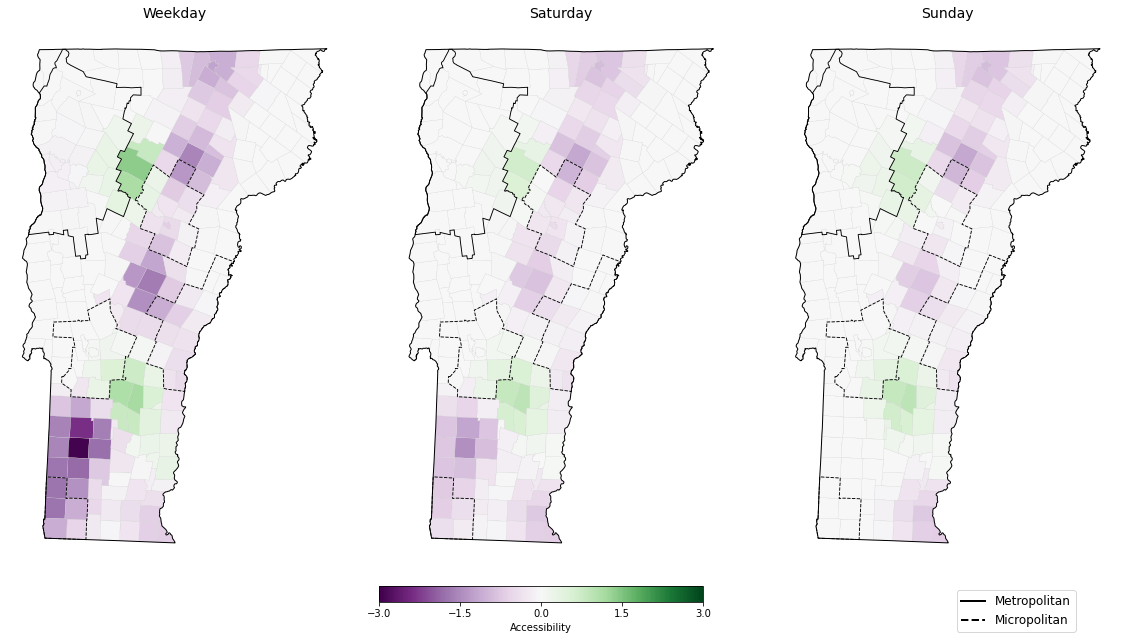

In [379]:
# Map accessibility by day of the week
mapping_df1 = mapping_df

extreme = math.ceil(max([abs(mapping_df1[['access_w', 'access_s', 'access_su']].min().min()),  # Min accessibility value
mapping_df1[['access_w', 'access_s', 'access_su']].max().max()]))  # Max accessibility value

fig3, axs = plt.subplots(1, 3, figsize=(22.5, 10), facecolor = 'white')
plt.subplots_adjust(wspace=-.4)

for i, column in enumerate(['access_w', 'access_s', 'access_su']):
    ax = axs[i]
    mapping_df1.plot(column=column, cmap='PRGn', linewidth=0.2, ax=ax, edgecolor='0.8', legend=False,
                vmin=-extreme, vmax=extreme)
    mapping_df1.dissolve().boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Plot only the merged exterior boundaries of the 'Metropolitan NECTA' group
    metropolitan_boundary.plot(ax=ax, color='black', linewidth=.9)

    # Plot only the merged exterior boundaries of the 'Micropolitan NECTA' group
    micropolitan_boundary.plot(ax=ax, color='black', linestyle = 'dashed', linewidth=.9)
    
    axs[0].set_title(label='a) Weekday', fontsize=14)
    axs[1].set_title('b) Saturday', fontsize=14)
    axs[2].set_title('c) Sunday', fontsize=14)
    ax.axis('off')

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=-extreme, vmax=extreme), cmap='PRGn'), ax=axs, #Max was set to 20 for visualization purposes
                    orientation='horizontal', pad=.02, shrink=.2)
cbar.set_label('Difference in Accessibility')
cbar.set_ticks([-extreme, -(extreme/2), 0, extreme/2, extreme])

#fig.patch.set_edgecolor('black') # Figure Border
#fig.patch.set_linewidth(2)       # Figure Border
plt.subplots_adjust(right=1)

cbar.ax.set_position([0.45, 0.05, .2, 0.05])

ax.legend(handles=legend_elements, loc='lower right', fontsize=12, bbox_to_anchor=(.9,-.129))

plt.show()

#Save Figure
if figsave:
    fig3.savefig(make_fig_file(3), dpi=300)

**Figure 3**. Spatial accessibility across days of the week. Each map represents the maximum accessibility on each day when all pharmacies that plan to open that day are operational. 

#### Statistical Significance

Distribution is not normal. Cannot use ANOVA test. Use Kruskal-Wallis instead.


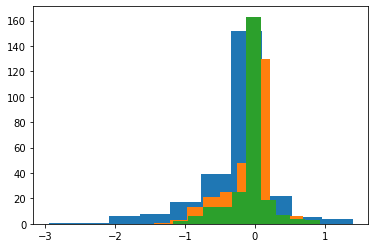

In [380]:
access_w_test = pd.Series(mapping_df['access_w'])
access_s_test = pd.Series(mapping_df['access_s'])
access_su_test = pd.Series(mapping_df['access_su'])

# Check for distribution between days of week. 
plt.hist(access_w_test, bins=10) 
plt.hist(access_s_test , bins=10) 
plt.hist(access_su_test, bins=10) 
print("Distribution is not normal. Cannot use ANOVA test. Use Kruskal-Wallis instead.")

In [381]:
# Run Kruskal-Wallis Test
h_statistic_2, p_value_2 = kruskal(access_w_test, access_s_test, access_su_test)
                 
print("Kruskal-Wallis H Statistic:", h_statistic_2)
print("P-value:", p_value_2)

alpha = 0.05
if p_value_2 < alpha:
    print("Reject the null hypothesis. There is a significant difference in mean access between weekdays, Saturdays, and Sundays.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in mean access between days.")
                    

Kruskal-Wallis H Statistic: 26.063169076587148
P-value: 2.1900536027506004e-06
Reject the null hypothesis. There is a significant difference in mean access between weekdays, Saturdays, and Sundays.


In [382]:
dunn_data = np.concatenate([access_w_test, access_s_test, access_su_test])
dunn_groups = ['access_w_test']*len(access_w_test) + ['access_s_test']*len(access_s_test) + ['access_su_test']*len(access_su_test)
dunn_df = pd.DataFrame({'value': dunn_data, 'group': dunn_groups})

# Perform Dunn's test with p-value adjustment (e.g., 'holm')
dunn_results = sp.posthoc_dunn(dunn_df, val_col='value', group_col='group', p_adjust='holm')
print("\nDunn's Post Hoc Test Results (p-values):\n", dunn_results)


Dunn's Post Hoc Test Results (p-values):
                 access_s_test  access_su_test  access_w_test
access_s_test        1.000000        0.005196       0.039007
access_su_test       0.005196        1.000000       0.000001
access_w_test        0.039007        0.000001       1.000000


### Hypothesis 3 - Spatio-Temporal Dynamics

Calculate mean access by NECTA classification and type of day. Simplify NECTA classification to rural and urban categories by merging micropolitan and metropolitan into "urban". Then calculate the percentage change from urban to rural for each type of day by finding the normalized percent difference with:  
`(Metro - Micro Access) / (Metro + Micro) * 100`  
`(Metro - Rural Access) / (Metro + Rural) * 100`  
`(Micro - Rural Access) / (Micro + Rural) * 100`

In [383]:
# Accessibility by Day and metropolitan/micropolitan Table
means_by_metro = mapping_df.groupby('necta').mean()[['access_w','access_s','access_su']]
means_by_metro = means_by_metro.rename(columns={"access_w": "Weekday", 
                                                "access_s": "Saturday",
                                                "access_su": "Sunday"})
means_by_metro = means_by_metro.transpose()
means_by_metro = means_by_metro.rename(columns={"Metropolitan": "Metro", 
                                                "Micropolitan": "Micro"})

def pctdiff(df, col1, col2):
    newcol = col1 + "_" + col2
    df[newcol] = (df[col1] - df[col2])/(df[col1] + df[col2]) * 100
    return df

means_by_metro = round(pctdiff(means_by_metro, "Metro", "Micro"), 2)
means_by_metro = round(pctdiff(means_by_metro, "Metro", "Rural"), 2)
means_by_metro = round(pctdiff(means_by_metro, "Micro", "Rural"), 2)

means_by_metro

# print(tabulate(means_by_metro, tablefmt = 'fancy_grid', headers=["","N","Weekday Mean Access", "Saturday Mean Access", "Sunday Mean Access"]))
#means_by_metro

necta,Metro,Micro,Rural,Metro_Micro,Metro_Rural,Micro_Rural
Weekday,0.00,-0.31,-0.26,-101.90,-100.00,8.77
Saturday,0.02,-0.16,-0.16,-132.94,-128.57,-0.00
Sunday,0.03,-0.05,-0.09,-466.94,-200.00,-28.57


**Table 1.** Mean Accessibility on weekdays, Saturdays, and Sundays, broken down by Metropolitan, Micropolitan, and Rural county subdivisions.
Normalized percent differences are calculated to see how accessibility gaps differ throughout the week. 